# Prototype Model
---

* Regression
* 2009 data로 class1,2,3 10fold


https://docs.google.com/presentation/d/1cI3teBcQoGBhfrdVrv9rnM4jHGaPToDS7Zh7t0q7GKg/edit#slide=id.g97e66187c6_0_6

In [1]:
import tensorflow as tf

In [2]:
from random import seed as random_seed
random_seed(50)
from numpy.random import seed as np_random_seed
np_random_seed(50)

tf.random.set_seed(50)

In [3]:
import os

os.sys.path.append(r'/docker_mnt/data5/jin/jin/python/')

os.sys.path

['/sgcwhb/Malocclusion/regression/bom',
 '/root/miniconda3/lib/python37.zip',
 '/root/miniconda3/lib/python3.7',
 '/root/miniconda3/lib/python3.7/lib-dynload',
 '',
 '/root/miniconda3/lib/python3.7/site-packages',
 '/root/miniconda3/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython',
 '/docker_mnt/data5/jin/jin/python/']

In [4]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5540561172190092162,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3683720445205830424
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48242412749
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4076752491998486111
 physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:3d:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6465901863421630491
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

import glob
import os
import pprint
from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

# Data Science
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

env: PYTHONHASHSEED=0


## Paths
---

In [17]:
so_type = 'so_rl'

input_path_root = r'../../data/input_data/'

# <model 저장>
# output_path_root = r'../results/'
output_path_root = r'../../results/fixed/1.5_10fold_prototype_rg_multiO3_so_img/'
output_path = os.path.join(output_path_root,  so_type)
output_path_weight = os.path.join(output_path, r'weights/')

try:
    os.makedirs(output_path_weight) 
    
except FileExistsError as err:      
    print(err)
# else:
#     print(output_path)
#     print(output_path_weight)

[Errno 17] File exists: '../../results/fixed/1.5_10fold_prototype_rg_multiO3_so_img/so_rl/weights/'


In [18]:
input_path_root

'../../data/input_data/'

In [19]:
output_path_root

'../../results/fixed/1.5_10fold_prototype_rg_multiO3_so_img/'

## Data
---
- Class 0 : 분별하기 어려운 data (65 sample) -> 제외

- Class 3 : 하악이 상악보다 앞으로 돌출된 경우 (1136 sample) -> -1.0
- Class 1 : 상하악의 맞물림 상태는 정상이지만 치열이 고르지 않은 경우 (1707 sample) -> 0.0
- Class 2 : 상악이 하악보다 앞으로 돌출된 경우 (1175 sample) -> 1.0


In [20]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0
    label_df.loc[label_r == 2, 'angle_class_r'] = 1
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

def generate_data_by_patient(x, y, y_distance):
    if x.shape[-1] == 12:
        x = np.concatenate([x[..., :3], x[..., 3:6], x[..., 6:9], x[..., 9:]]) 
        y = np.concatenate([y[:, 0], y[:, 1], y[:, 2], y[:, 3]])
    elif x.shape[-1] == 6:
        x = np.concatenate([x[..., :3], x[..., 3:]]) # Right side,Left side !!!
        
        y_r_test= to_categorical(y[:,0], num_classes=3)
        y_l_test= to_categorical(y[:,1], num_classes=3)
        
        y = np.concatenate([y[:, 0], y[:, 1]])
        y_onehot=np.concatenate((y_r_test,y_l_test),axis=0)
        
        y_distance = np.concatenate([y_distance[:, 0], y_distance[:, 1]])
    
    return x, y, y_onehot, y_distance

# def generate_info_df_by_patient(info_df):
#     info_df_r = info_df.copy()
#     for row_idx, info in enumerate(info_df_r['info']):
#         info_df_r.iloc[row_idx] = info + '_r'
        
#     info_df_l = info_df.copy()
#     for row_idx, info in enumerate(info_df_l['info']):
#         info_df_l.iloc[row_idx] = info + '_l'
    
#     info_df = pd.concat((info_df_r, info_df_l), ignore_index=True)
#     del info_df_r, info_df_l
    
#     info_df1 = info_df.copy()
        
#     info_df2 = info_df.copy()
#     for row_idx, info in enumerate(info_df2['info']):
#         info_df2.iloc[row_idx] = info.replace('01A1', '02B1')
    
#     info_df = pd.concat((info_df1, info_df2), ignore_index=True)
#     del info_df1, info_df2

#     return info_df

In [22]:
x = np.load(os.path.join(input_path_root, f'data_KNU_Diorco_so_imgs.npy'))
label_df = pd.read_csv(os.path.join(input_path_root, f'data_Diorco_label.csv'))
label_df = convert_label_class2reg(label_df)

y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()
y_distance= label_df.loc[:, ['distance(r)', 'distance(l)']].to_numpy()

x = x.astype(np.float32)
y = y.astype(np.float32)
y_distance = y_distance.astype(np.float32)

x = x / 127.5
x = x - 1.

#x = np.concatenate((x[::2, ...], x[1::2, ...]), axis=3)
#y = np.concatenate((y[::2, ...], y[1::2, ...]), axis=1)

In [23]:
#---------onehot function test------------------
x_tt, y_tt, y_onehot_tt,y_distance_tt=generate_data_by_patient(x,y,y_distance)

y_onehot_tt_r=y_onehot_tt[:(y_onehot_tt.shape[0]//2)]
y_onehot_tt_l=y_onehot_tt[(y_onehot_tt.shape[0]//2):]

y_onehot_tt_r=list(y_onehot_tt_r)
y_onehot_tt_l=list(y_onehot_tt_l)

print("regression:",y_tt.min(),"||",y_tt.max())
print("classification:",y_onehot_tt.min(),"||",y_onehot_tt.max())
print("distance:",y_distance_tt.min(),"||",y_distance_tt.max())

label_df["one-hot-r"]=y_onehot_tt_r
label_df["one-hot-l"]=y_onehot_tt_l
label_df

#---------------------------------------------

regression: -1.0 || 1.0
classification: 0.0 || 1.0
distance: -24.48 || 25.12


,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
2006,QH1072,Post-Tx,1,1,7.41,5.26,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"


float32 (2009, 480, 784, 6)
float32 (2009, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     2009 non-null   object 
 1   tx_phase       2009 non-null   object 
 2   angle_class_r  2009 non-null   int64  
 3   angle_class_l  2009 non-null   int64  
 4   distance(r)    2009 non-null   float64
 5   distance(l)    2009 non-null   float64
 6   one-hot-r      2009 non-null   object 
 7   one-hot-l      2009 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 125.7+ KB


None

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
2006,QH1072,Post-Tx,1,1,7.41,5.26,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"


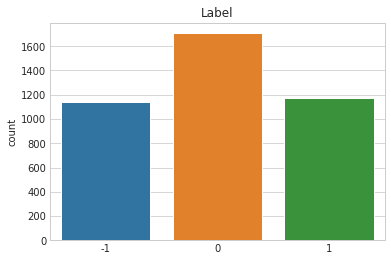

In [24]:
print(x.dtype, x.shape)
print(y.dtype, y.shape)
print()
display.display(label_df.info())
display.display(label_df)

plt.style.use('seaborn-whitegrid')
plt.figure()

plt.title('Label')
sns.countplot(np.concatenate([label_df.angle_class_r, label_df.angle_class_l]))

plt.show()
plt.style.use('seaborn-white')

In [25]:
cnt = np.concatenate([label_df.angle_class_r, label_df.angle_class_l])


print("calss -1:",len(cnt[cnt==-1]))
print("calss 0:",len(cnt[cnt==0]))
print("calss 1:",len(cnt[cnt==1]))

calss -1: 1136
calss 0: 1707
calss 1: 1175


## Model
---

In [26]:
def build_model():
    base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(None, None, 3))

#     base_model.trainable = False

#     for layer in base_model.layers:
#         layer.trainable = False

    # base_model.summary()

    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(256, activation='relu', name='dense')(x)
    x = layers.Dropout(0.2, name='dropout')(x)
    
    regression_prediction=layers.Dense(1, name='regression_prediction')(x)
    one_hot_prediction=layers.Dense(3, activation='softmax', name='classification')(regression_prediction)
    distance_prediction=layers.Dense(1, name='distance_prediction')(x)

    
    model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
#     model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
    
    return model

In [15]:
model=build_model()

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
# model.compile(optimizer=optimizers.Adam(lr=1e-3),
#                       loss=["mae","categorical_crossentropy","mae"],
#                       metrics=["acc","mae"])
model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
              loss_weights={'regression_prediction':1,'classification':1,'distance_prediction':1.5},
              metrics=["acc","mae"])

## Train the Model
---

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])): #left???

    display.clear_output(wait=True)
    print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

    # 1. Data
    # ----------------------------------------

#------DEBUG--------:
#     print(test_idxs)     
#     print(np.unique(y[test_idxs, 0], return_counts=True))
#-------------------   

    x_train = x[train_idxs]
    y_train = y[train_idxs]
    y_distance_train =y_distance[train_idxs]
#     label_df_train = label_df.iloc[train_idxs]

    x_train, x_val, y_train, y_val, y_distance_train, y_distance_val = train_test_split(x_train, y_train, y_distance_train, test_size=0.2, 
                                                                                    random_state=42, stratify=y_train[:, 0])

    x_test = x[test_idxs]
    y_test = y[test_idxs]
    y_distance_test =y_distance[test_idxs]
#     label_df_test = label_df.iloc[test_idxs]

    #distance 누락!
    x_train, y_train,y_train_onehot, y_train_distance = generate_data_by_patient(x_train, y_train, y_distance_train)
    x_val, y_val, y_val_onehot, y_val_distance = generate_data_by_patient(x_val, y_val, y_distance_val)
    x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test, y_distance_test)

    weight_for_m1 = (1 / len(y_train[y_train==-1]))*(len(y_train))/3.0 
    weight_for_0 = (1 / len(y_train[y_train==0]))*(len(y_train))/3.0 
    weight_for_1 = (1 / len(y_train[y_train==1]))*(len(y_train))/3.0

    class_weight=[weight_for_m1,weight_for_0,weight_for_1]

#------DEBUG--------:
#     print(len(y_train))
#     print("class -1;",len(y_train[y_train==-1]))
#     print("class 0;",len(y_train[y_train==0]))
#     print("class 1;",len(y_train[y_train==1]))

#     print("-------------")
#     print(weight_for_m1)
#     print(weight_for_0)
#     print(weight_for_1)

#------------------- 


    # DEBUG:
#     plt.figure(figsize=(8, 6))

#     plt.subplot(121)
#     data_idx1 = 1
#     plt.title(info_train.iloc[data_idx1, 0])
#     plt.imshow((x_train[data_idx1] + 1) / 2)
#     plt.xlabel(f'Label: {y_train[data_idx1]}')

#     plt.subplot(122)
#     data_idx2 = data_idx1 + len(x_train) // 4
#     plt.title(info_train.iloc[data_idx2, 0])
#     plt.imshow((x_train[data_idx2] + 1) / 2)
#     plt.xlabel(f'Label: {y_train[data_idx2]}')

#     plt.show()
#     print(x_train.dtype, x_train.shape)
#     print(y_train.dtype, y_train.shape)
#     print()
#     print(x_val.dtype, x_val.shape)
#     print(y_val.dtype, y_val.shape)
#     print()
#     print(x_test.dtype, x_test.shape)
#     print(y_test.dtype, y_test.shape)

    # 2. Paths
    # ----------------------------------------

    output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
    output_path_weight = os.path.join(output_path_kfold, r'weights/')

    if os.path.isdir(output_path_weight)==False:
        os.makedirs(output_path_weight)

    # 3. Build a Model.
    # ----------------------------------------

    if kfold_idx == 0:
        model = build_model()

        model.compile(optimizer=optimizers.Adam(lr=1e-3),
                      loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
                      loss_weights={'regression_prediction':1,'classification':1,'distance_prediction':1.5},
                      metrics=["acc","mae"])

        model.save(os.path.join(output_path, r'model.hdf5'))

        # model.summary()
    else:
        model = models.load_model(os.path.join(output_path, r'model.hdf5'))

    # 4. Train the Model.
    # ----------------------------------------

    # Callbacks
    checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'),
                                             save_weights_only=True)
    csv_logger = callbacks.CSVLogger(os.path.join(output_path_kfold, r'log.csv'), append=True)


    # Training batch size 16 -> 8
    model.fit(x_train,{'regression_prediction':y_train, 'classification':y_train_onehot,'distance_prediction':y_train_distance},
              batch_size=8,
              epochs=50,
              validation_data=(x_val, {'regression_prediction':y_val,'classification':y_val_onehot,'distance_prediction':y_val_distance}),
              callbacks=[checkpointer, csv_logger],
              initial_epoch=0,
              class_weight=[class_weight,class_weight,class_weight],
              verbose=1)

    K.clear_session()
    del model

## Evaluation
---

In [21]:
info_df = label_df.copy()
info_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
2006,QH1072,Post-Tx,1,1,7.41,5.26,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"


In [22]:
info_df.iloc[[0,3,5,6,7]]

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
5,QH0044,Post-Tx,1,1,9.15,7.06,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
6,QH0059,Pre-Tx,0,0,1.13,0.81,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
7,QH0059,Post-Tx,1,-1,1.53,0.49,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"


In [184]:
output_path

'../../results/fixed/1.5_10fold_prototype_rg_multiO3_so_img/so_rl'

K-Fold CV: 01/10
[   4    6   28   31   33   38   44   49   50   65   71   74   80   93
   94   96  122  153  167  175  237  242  245  250  256  267  269  276
  278  290  291  294  304  310  313  322  328  331  333  344  347  349
  350  364  376  380  414  431  435  458  464  478  499  505  523  528
  557  562  567  580  585  601  603  609  611  625  631  644  656  658
  661  667  671  672  695  710  711  715  720  746  750  754  758  759
  802  803  804  820  838  842  846  848  874  875  881  890  895  900
  905  930  932  943  956  976  997 1013 1017 1020 1032 1033 1039 1076
 1078 1080 1095 1097 1108 1111 1117 1143 1150 1155 1165 1172 1173 1181
 1206 1209 1232 1238 1249 1250 1255 1258 1260 1274 1286 1312 1315 1319
 1348 1361 1364 1420 1443 1444 1450 1458 1470 1498 1502 1516 1524 1553
 1574 1593 1611 1653 1663 1671 1683 1691 1697 1702 1705 1707 1716 1731
 1735 1742 1752 1761 1762 1768 1777 1791 1792 1793 1794 1799 1802 1814
 1818 1867 1871 1874 1878 1887 1903 1912 1938 1943 1946 1947

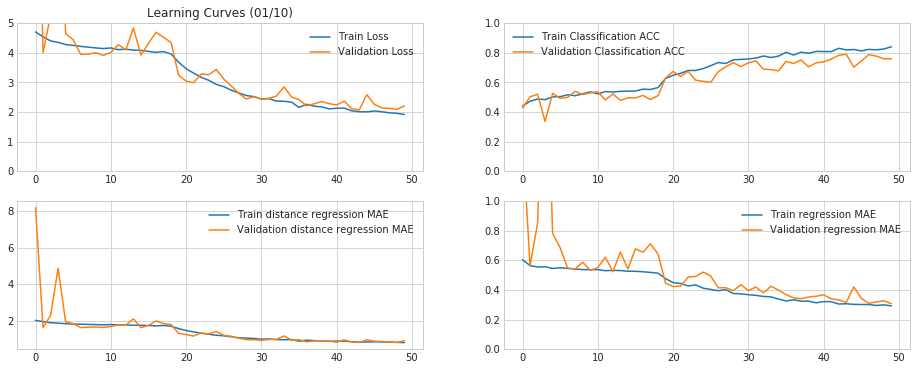

Min. validation loss epoch: 44
Max. Classification ACC epoch: 44
Max. Classification ACC: 0.7900553000000001
Min. distance regression validation MAE epoch: 49
Min. regression validation MAE epoch: 50
K-Fold CV: 02/10
[  42   46   51   64   68   72   73   98  121  129  141  150  158  165
  196  201  220  221  234  236  247  251  277  283  286  308  319  338
  342  353  357  372  402  404  418  421  422  444  445  469  475  482
  485  492  494  519  536  549  558  563  564  575  576  579  584  593
  605  617  634  662  666  674  702  703  705  721  724  726  729  731
  734  736  738  752  753  765  770  783  807  847  853  861  866  869
  878  903  904  909  919  920  924  939  945  947  953  957  963  974
  980  982  984  986  991  995  998 1015 1024 1035 1042 1050 1052 1055
 1074 1085 1086 1118 1124 1129 1140 1144 1156 1183 1193 1194 1207 1223
 1239 1240 1242 1252 1257 1272 1282 1314 1318 1325 1326 1332 1336 1347
 1349 1366 1374 1389 1399 1401 1416 1423 1431 1440 1452 1463 1464 1482
 1

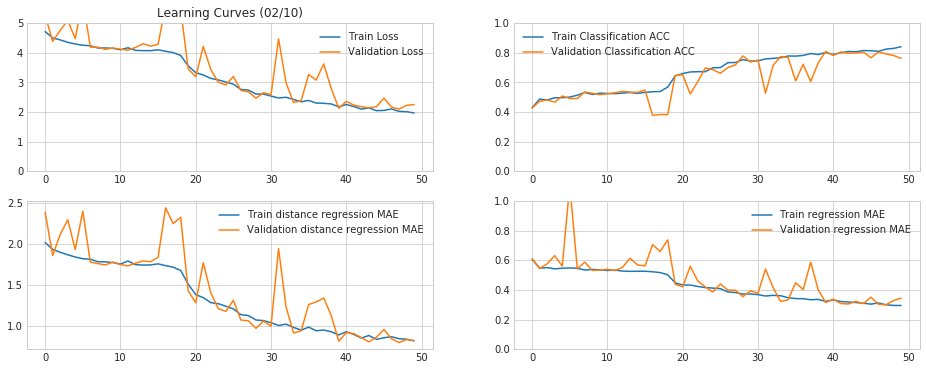

Min. validation loss epoch: 48
Max. Classification ACC epoch: 40
Max. Classification ACC: 0.8093923000000001
Min. distance regression validation MAE epoch: 48
Min. regression validation MAE epoch: 48
K-Fold CV: 03/10
[   5    7   11   13   29   35   52   57   60   88   92   97   99  104
  109  142  147  157  170  177  182  185  197  203  257  259  275  280
  282  320  321  345  352  358  365  389  395  405  411  436  439  440
  442  473  480  486  495  497  512  524  529  551  555  556  565  569
  578  588  596  597  602  604  614  632  641  681  685  687  692  698
  707  730  776  781  785  791  793  796  797  812  818  844  854  864
  865  873  892  902  907  911  913  914  925  926  928  935  954  955
  964  969 1018 1029 1034 1041 1049 1057 1061 1075 1083 1094 1107 1145
 1147 1174 1175 1176 1177 1185 1190 1196 1203 1212 1222 1225 1237 1248
 1254 1268 1273 1285 1300 1327 1333 1342 1352 1354 1370 1384 1411 1424
 1426 1434 1435 1437 1453 1459 1483 1492 1506 1509 1520 1522 1526 1528
 1

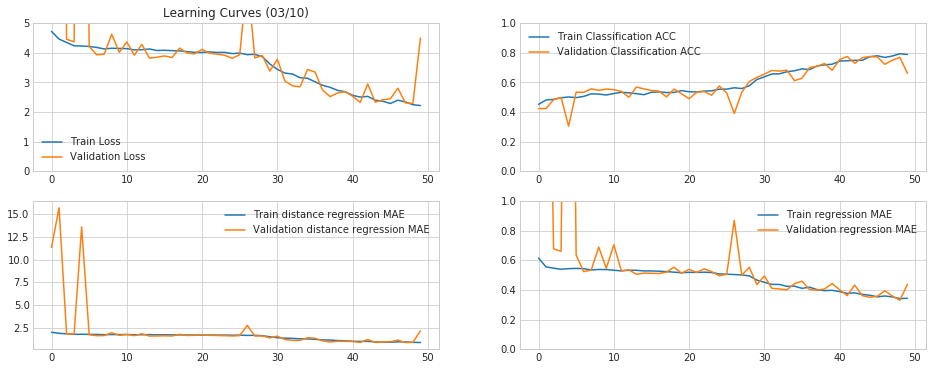

Min. validation loss epoch: 49
Max. Classification ACC epoch: 42
Max. Classification ACC: 0.7748619000000001
Min. distance regression validation MAE epoch: 48
Min. regression validation MAE epoch: 49
K-Fold CV: 04/10
[  41   48   56   63   66   70   89   91  100  103  106  117  125  130
  135  159  163  174  178  180  189  191  199  212  219  228  233  268
  271  284  296  299  303  306  311  312  314  325  330  336  359  360
  362  377  381  391  420  427  432  443  449  455  459  471  477  481
  483  489  518  520  534  541  566  570  591  607  620  627  645  651
  652  668  673  675  676  696  700  716  732  733  737  761  786  799
  806  827  835  837  862  872  883  889  894  901  906  910  922  923
  927  931  941  948  965  967  971  972  994 1002 1006 1008 1010 1016
 1028 1051 1054 1065 1077 1099 1100 1101 1103 1106 1109 1112 1125 1135
 1148 1152 1153 1159 1197 1198 1208 1217 1228 1244 1270 1281 1287 1291
 1303 1316 1330 1355 1372 1378 1382 1385 1386 1387 1410 1414 1428 1429
 1

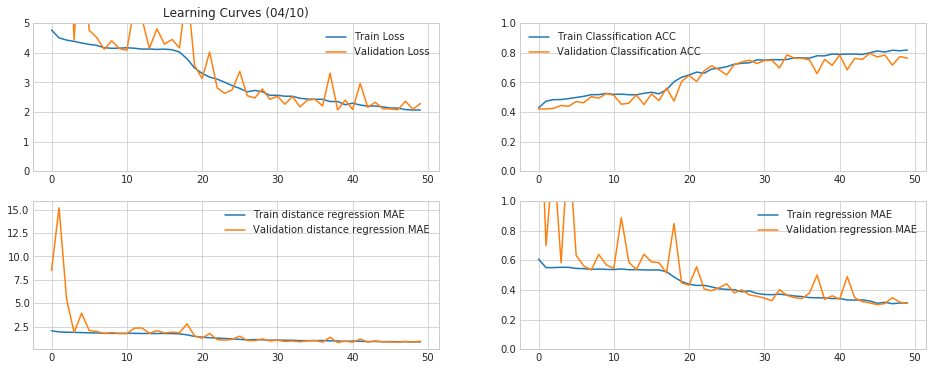

Min. validation loss epoch: 39
Max. Classification ACC epoch: 45
Max. Classification ACC: 0.7955800999999999
Min. distance regression validation MAE epoch: 39
Min. regression validation MAE epoch: 46
K-Fold CV: 05/10
[   0    1   15   18   22   26   36   43   67   77   78  114  116  136
  140  146  148  154  166  171  173  181  193  200  208  225  226  249
  274  289  297  309  326  327  332  335  354  356  363  369  373  384
  399  407  410  417  424  434  446  468  470  509  514  521  527  530
  531  532  539  548  574  583  599  606  623  630  639  640  647  654
  657  682  684  690  694  706  728  747  755  757  772  780  784  795
  811  814  823  826  834  836  850  851  893  917  938  942  951  975
  981  993 1009 1011 1014 1019 1021 1023 1025 1027 1036 1046 1053 1059
 1067 1084 1087 1126 1131 1149 1158 1161 1162 1167 1179 1202 1283 1290
 1293 1294 1302 1309 1321 1335 1338 1339 1340 1344 1351 1363 1388 1400
 1405 1408 1421 1430 1438 1442 1461 1469 1475 1476 1484 1487 1499 1504
 1

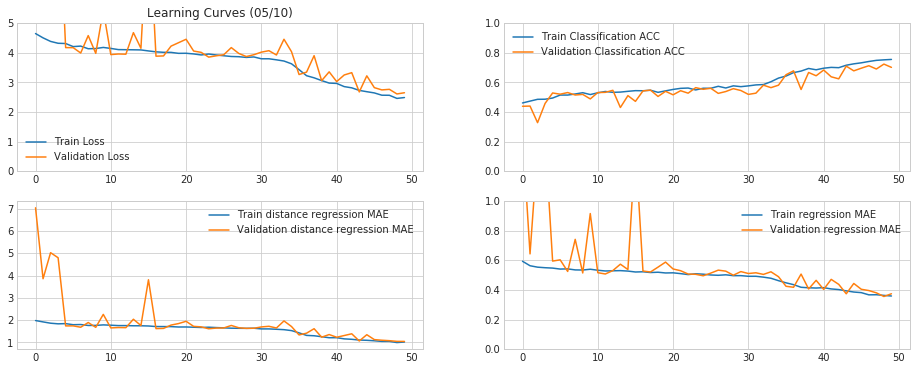

Min. validation loss epoch: 49
Max. Classification ACC epoch: 49
Max. Classification ACC: 0.7237569
Min. distance regression validation MAE epoch: 50
Min. regression validation MAE epoch: 49
K-Fold CV: 06/10
[  10   30   45   55   61   62   82   85  107  110  111  118  119  126
  131  137  143  144  156  160  179  188  195  202  231  232  240  246
  252  272  279  292  295  305  317  318  323  329  341  343  368  374
  379  394  396  400  403  408  409  426  428  437  447  456  488  500
  507  510  511  516  517  540  543  552  560  568  577  586  608  612
  615  629  659  663  670  686  693  739  742  798  808  815  824  829
  830  831  841  845  849  852  859  877  915  918  966  968  970  978
  990 1005 1038 1044 1045 1062 1071 1072 1088 1105 1113 1115 1120 1130
 1137 1139 1141 1146 1151 1154 1171 1186 1195 1200 1205 1210 1243 1259
 1263 1266 1269 1280 1288 1292 1297 1301 1306 1350 1356 1358 1369 1398
 1402 1409 1432 1436 1447 1473 1479 1480 1514 1515 1534 1536 1539 1550
 1570 1616 

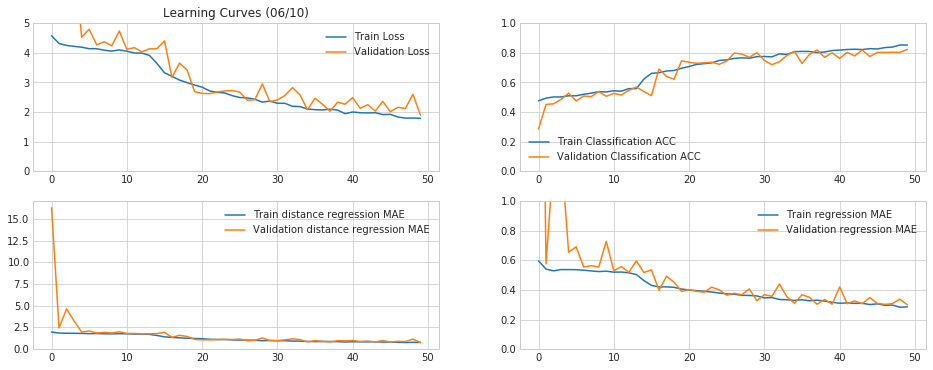

Min. validation loss epoch: 50
Max. Classification ACC epoch: 50
Max. Classification ACC: 0.8232044
Min. distance regression validation MAE epoch: 50
Min. regression validation MAE epoch: 50
K-Fold CV: 07/10
[   9   20   23   25   34   69   76   83   87  105  133  134  155  161
  184  187  204  206  211  218  239  243  244  253  255  262  265  288
  334  337  339  370  371  375  386  387  393  415  429  438  451  453
  454  462  465  479  487  490  498  506  508  513  533  535  545  559
  587  589  590  594  595  610  613  618  621  636  637  642  655  680
  683  689  697  699  704  709  717  722  745  749  751  768  773  777
  779  790  792  794  800  809  833  856  871  880  885  888  898  912
  929  961  973  983  987  996  999 1003 1022 1063 1102 1104 1110 1116
 1123 1128 1132 1133 1136 1160 1169 1170 1182 1189 1199 1218 1224 1233
 1236 1267 1276 1284 1295 1320 1322 1334 1341 1343 1345 1346 1365 1367
 1371 1375 1379 1390 1391 1392 1397 1419 1422 1486 1507 1543 1545 1552
 1559 1577 

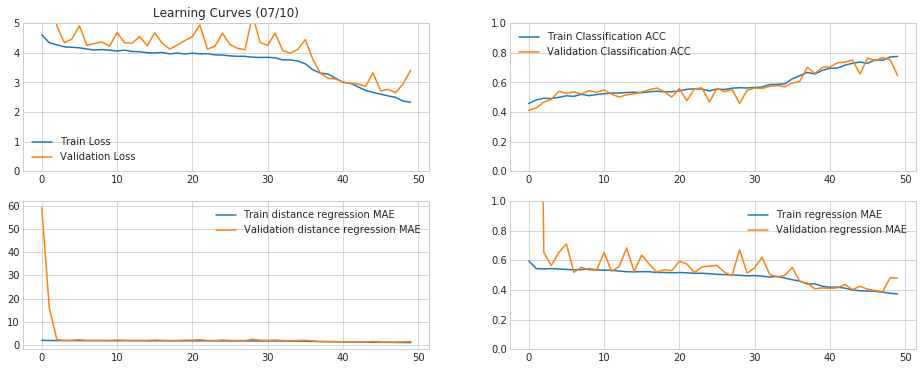

Min. validation loss epoch: 48
Max. Classification ACC epoch: 48
Max. Classification ACC: 0.7679558000000001
Min. distance regression validation MAE epoch: 48
Min. regression validation MAE epoch: 48
K-Fold CV: 08/10
[  12   16   19   32   40   54   58   59   84   90  124  127  149  162
  168  169  186  192  209  213  214  238  258  273  281  285  293  298
  301  302  307  316  324  355  366  378  382  392  401  419  425  457
  472  484  502  503  504  526  544  626  633  635  638  643  650  653
  660  664  669  688  701  714  725  727  756  763  769  771  775  805
  810  817  825  828  832  855  870  882  897  936  940  944  949  950
  952  962  985  992 1000 1001 1004 1040 1069 1079 1082 1090 1098 1121
 1122 1138 1163 1187 1191 1201 1211 1220 1221 1229 1230 1231 1246 1253
 1275 1277 1299 1317 1323 1328 1329 1360 1368 1373 1376 1377 1380 1381
 1383 1393 1394 1403 1407 1412 1413 1427 1433 1441 1448 1454 1457 1460
 1462 1466 1468 1489 1490 1493 1495 1508 1511 1517 1527 1532 1537 1546
 1

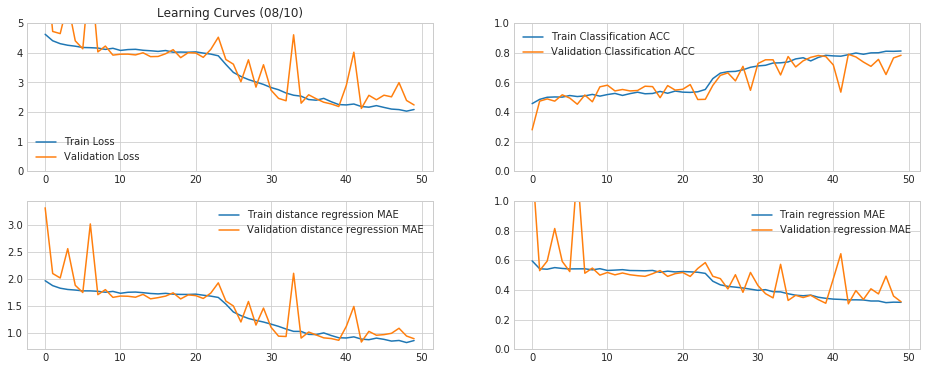

Min. validation loss epoch: 43
Max. Classification ACC epoch: 43
Max. Classification ACC: 0.7900553000000001
Min. distance regression validation MAE epoch: 43
Min. regression validation MAE epoch: 43
K-Fold CV: 09/10
[   2   14   47   53   75   81  101  102  115  123  132  139  183  190
  194  207  210  216  217  223  227  229  235  254  266  270  346  351
  383  385  390  397  398  413  416  423  430  433  452  460  463  466
  467  476  496  501  515  522  542  546  547  553  561  572  573  582
  598  616  619  624  648  691  708  712  713  718  723  740  767  778
  787  789  821  839  857  863  867  879  886  908  916  921  937  946
  959  960  979  989 1037 1043 1056 1058 1060 1064 1066 1070 1073 1091
 1092 1093 1096 1134 1157 1166 1168 1178 1188 1192 1215 1227 1235 1245
 1256 1262 1265 1271 1279 1298 1304 1310 1311 1324 1331 1337 1357 1359
 1395 1404 1417 1418 1439 1445 1446 1467 1474 1478 1485 1500 1503 1512
 1521 1530 1544 1548 1555 1557 1573 1576 1581 1582 1598 1612 1618 1625
 1

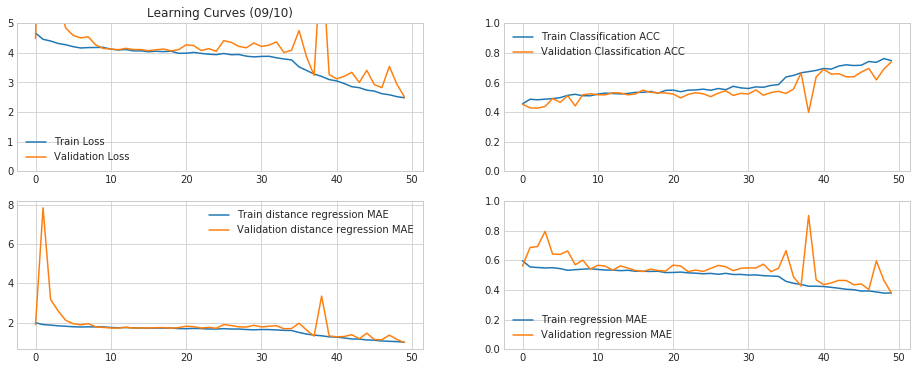

Min. validation loss epoch: 50
Max. Classification ACC epoch: 50
Max. Classification ACC: 0.73895025
Min. distance regression validation MAE epoch: 50
Min. regression validation MAE epoch: 50
K-Fold CV: 10/10
[   3    8   17   21   24   27   37   39   79   86   95  108  112  113
  120  128  138  145  151  152  164  172  176  198  205  215  222  224
  230  241  248  260  261  263  264  287  300  315  340  348  361  367
  388  406  412  441  448  450  461  474  491  493  525  537  538  550
  554  571  581  592  600  622  628  646  649  665  677  678  679  719
  735  741  743  744  748  760  762  764  766  774  782  788  801  813
  816  819  822  840  843  858  860  868  876  884  887  891  896  899
  933  934  958  977  988 1007 1012 1026 1030 1031 1047 1048 1068 1081
 1089 1114 1119 1127 1142 1164 1180 1184 1204 1213 1214 1216 1219 1226
 1234 1241 1247 1251 1261 1264 1278 1289 1296 1305 1307 1308 1313 1353
 1362 1396 1406 1415 1425 1449 1451 1455 1465 1471 1481 1488 1491 1496
 1501 1510

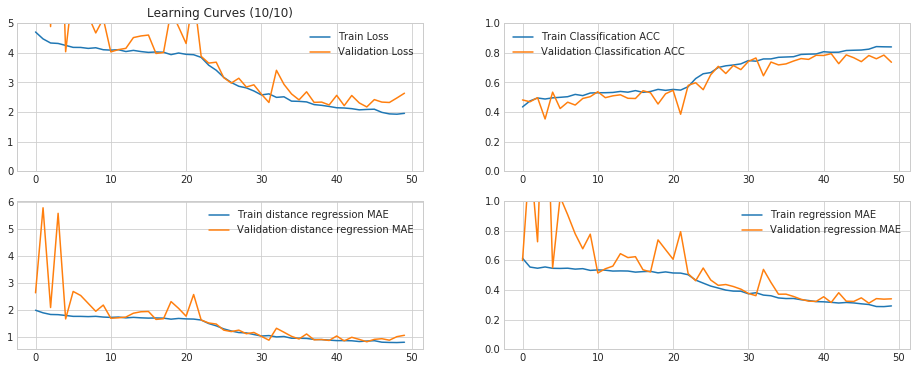

Min. validation loss epoch: 45
Max. Classification ACC epoch: 42
Max. Classification ACC: 0.7941989
Min. distance regression validation MAE epoch: 45
Min. regression validation MAE epoch: 47


In [36]:
metrics = []
predictions_kfold = []
labels_kfold = []
distance_regression = [] 

total_info =[]
total_info_2 =[]

fold_testidx=[]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# model_parm_name="D"+depth+"_"+dropout_rat

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):


    print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

    print(test_idxs)
    fold_testidx.append(test_idxs)
    # 1. Data
    # ----------------------------------------

    x_test = x[test_idxs]
    y_test = y[test_idxs]
    y_test_distance= y_distance[test_idxs]

    label_df_test = label_df.iloc[test_idxs]

    x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test,y_test_distance)

    # 2. Paths
    # ----------------------------------------

#     output_path_kfold = os.path.join(output_path, model_parm_name, f'kfold_{kfold_idx + 1:02d}/')
    output_path_kfold = os.path.join(output_path,  f'kfold_{kfold_idx + 1:02d}/')
    output_path_weight = os.path.join(output_path_kfold, r'weights/')

    # 3. Plot Learning Curves.
    # ----------------------------------------

    # log 저장: loss, mae, val_loss, val_mae
    log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))


    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(16, 6))

    plt.subplot(2,2,1)
    plt.title(f'Learning Curves ({kfold_idx + 1:02d}/{kfold.n_splits:02d})')
    plt.plot(log_df.loss)
    plt.plot(log_df.val_loss)
    plt.ylim(0, 5)
    plt.legend(('Train Loss', 'Validation Loss'))

    plt.subplot(2,2,2)
    plt.plot(log_df.classification_acc)
    plt.plot(log_df.val_classification_acc)
    plt.ylim(0, 1)
    plt.legend(('Train Classification ACC', 'Validation Classification ACC'))

    plt.subplot(2,2,3)
    plt.plot(log_df.distance_prediction_mae)
    plt.plot(log_df.val_distance_prediction_mae)
    plt.legend(('Train distance regression MAE', 'Validation distance regression MAE'))

    plt.subplot(2,2,4)
    plt.plot(log_df.regression_prediction_mae)
    plt.plot(log_df.val_regression_prediction_mae)
    plt.ylim(0, 1)
    plt.legend(('Train regression MAE', 'Validation regression MAE'))

    plt.show()
    plt.style.use('seaborn-white')
    print(f'Min. validation loss epoch: {log_df.val_loss.idxmin() + 1}')
    print(f'Max. Classification ACC epoch: {log_df.val_classification_acc.idxmax() + 1}')
    print(f'Max. Classification ACC: {log_df.val_classification_acc[log_df.val_classification_acc.idxmax()]}')
    print(f'Min. distance regression validation MAE epoch: {log_df.val_distance_prediction_mae.idxmin() + 1}')
    print(f'Min. regression validation MAE epoch: {log_df.val_regression_prediction_mae.idxmin() + 1}')



    info_df = label_df.copy()

    result_info_df = info_df.iloc[test_idxs]

    inference_df = result_info_df.copy()
    inference_df2 = result_info_df.copy()

    # 4. Load a Model.
    # ----------------------------------------

    K.clear_session()

    #sgcwhb/Malocclusion/results/prototype_regression_so_img/so_rl/model.hdf5
    model = models.load_model(os.path.join(output_path, r'model.hdf5'))
    model2 = models.load_model(os.path.join(output_path, r'model.hdf5'))
    #validation mae가 가장 적은 model weight load
    model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_regression_prediction_mae.idxmin() + 1:08d}*.hdf5'))[0])
    model2.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_classification_acc.idxmax() + 1:08d}*.hdf5'))[0])
    # 5. Display
    # ----------------------------------------


    prediction = model.predict(x_test)
    prediction2 = model2.predict(x_test)

    prediction_distance_r = prediction[0][:int(prediction[0].shape[0]/2),0] #Right
    prediction_distance_l = prediction[0][int(prediction[0].shape[0]/2):,0] #left
    
    prediction_class_r = prediction2[1][:int(prediction[1].shape[0]/2)] #Right
    prediction_class_l = prediction2[1][int(prediction[1].shape[0]/2):] #left

    r = prediction_distance_r.copy()
    l = prediction_distance_l.copy()
    
    r2 = prediction_class_r.copy()
    l2 = prediction_class_l.copy()

    #-1~1사이 score
    r = np.round(r) #반올림
    r[r<-1]= -1
    r[r>1] = 1


    l = np.round(l)
    l[l<-1]= -1
    l[l>1] = 1  
    
    r2 = np.round(r2) #반올림
    r2= r2.tolist()
    r2_2=[]
    for xx in r2:
        if xx==[0.0,0.0,1.0]:
            xx=-1
        elif xx==[1.0,0.0,0.0]:
            xx=0
        else:
            xx=1
        r2_2.append(xx)
    
    l2 = np.round(l2)
    l2= l2.tolist()
    l2_2=[]
    for xy in l2:
        if xy==[0.0,0.0,1.0]:
            xy=-1
        elif xy==[1.0,0.0,0.0]:
            xy=0
        else:
            xy=1
        l2_2.append(xy)
#     print(l.shape)
#     print(r.shape)
#     print(info_df.shape)
#     print(result_info_df.shape)

    inference_df['prediction_class_r'] = r
    inference_df['prediction_class_l'] =l
    inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
    inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)

    inference_df2['prediction_class_r']=r2_2
    inference_df2['prediction_class_l']=l2_2
    inference_df2['prediction_onehot_class_r']=r2
    inference_df2['prediction_onehot_class_l']=l2
    

    inference_df.to_csv(os.path.join(output_path_kfold, r'info_v1.csv')) # log_df.val_regression_prediction_mae.idxmin()
    inference_df2.to_csv(os.path.join(output_path_kfold, r'info_v2.csv')) # log_df.val_classification_acc.idxmax()
    
    total_info.append(inference_df)
    total_info_2.append(inference_df2)

total_df = pd.concat(total_info)
total_df.to_csv(os.path.join(output_path,'total_v1.csv'))

total_df2 = pd.concat(total_info_2)
total_df2.to_csv(os.path.join(output_path,'total_v2.csv'))


In [37]:
total_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l,prediction_class_r,prediction_class_l,regression_distance_r,regression_distance_l
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1.0,1.0,1.101,0.902
6,QH0059,Pre-Tx,0,0,1.13,0.81,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0.0,0.0,0.105,0.070
28,QH0126,Pre-Tx,1,1,3.07,1.82,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0.0,-1.0,0.270,-0.620
31,QH0129,Post-Tx,0,-1,0.44,0.88,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",-0.0,-1.0,-0.403,-0.705
33,QH0145,Post-Tx,-1,-1,-1.54,-1.93,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1.0,-1.0,-1.106,-0.722
...,...,...,...,...,...,...,...,...,...,...,...,...
1937,QH0440,Pre-Tx,0,0,1.30,-0.04,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0.0,0.0,0.001,0.001
1960,QH0542,Pre-Tx,-1,-1,-11.05,-11.91,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1.0,-1.0,-1.424,-2.403
1967,QH0556,Post-Tx,0,0,-0.27,-0.60,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",-0.0,-1.0,-0.128,-0.549
1986,QH0884,Pre-Tx,-1,-1,-1.92,-4.50,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1.0,-1.0,-0.657,-1.276


In [38]:
total_df2

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l,prediction_class_r,prediction_class_l,prediction_onehot_class_r,prediction_onehot_class_l
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",1,1,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
6,QH0059,Pre-Tx,0,0,1.13,0.81,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
28,QH0126,Pre-Tx,1,1,3.07,1.82,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0,1,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
31,QH0129,Post-Tx,0,-1,0.44,0.88,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",0,-1,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"
33,QH0145,Post-Tx,-1,-1,-1.54,-1.93,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1,-1,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1937,QH0440,Pre-Tx,0,0,1.30,-0.04,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1960,QH0542,Pre-Tx,-1,-1,-11.05,-11.91,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1,-1,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
1967,QH0556,Post-Tx,0,0,-0.27,-0.60,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1986,QH0884,Pre-Tx,-1,-1,-1.92,-4.50,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",-1,-1,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"


In [39]:
total_df=pd.read_csv(os.path.join(output_path,'total_v1.csv'))

In [40]:
data = total_df['angle_class_r'].append(total_df['angle_class_l'])
prediction =  total_df['prediction_class_r'].append(total_df['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)

cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

[[ 686  439   11]
 [  74 1561   72]
 [   9  368  798]]

Accuracy: 0.758


In [41]:
total_df=pd.read_csv(os.path.join(output_path,'total_v2.csv'))

In [42]:
data = total_df['angle_class_r'].append(total_df['angle_class_l'])
prediction =  total_df['prediction_class_r'].append(total_df['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)

cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

[[ 779  318   39]
 [ 132 1388  187]
 [  13  252  910]]

Accuracy: 0.766


In [32]:
kfold_results_df = pd.DataFrame(metrics, columns=('test_loss', 'test_mae'))


In [63]:
kfold_results_df.describe()

,test_loss,test_mae
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


In [35]:
np.sum(cm)

4018